## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
from tqdm import tqdm
import warnings
warnings. filterwarnings("ignore") 
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.externals import joblib 
import matplotlib.pyplot as plt

In [2]:
!pip install lightgbm

### Reading data after the feature engineering

In [4]:
#reading train_data after the feature engineering
train_data=pd.read_csv("pilot_train_after_fe")

In [6]:
train_data.head(3)

,Unnamed: 0,crew,time,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,...,eeg_f3_alpha_high,eeg_fz_alpha_high,eeg_f4_alpha_high,eeg_c4_alpha_high,eeg_p4_alpha_high,eeg_poz_alpha_high,eeg_c3_alpha_high,eeg_cz_alpha_high,eeg_o2_alpha_high,e
0,0,1,0.011719,-5.28545,26.775801,-9.52731,-12.793200,16.717800,33.737499,23.712299,...,0.006548,0.001229,0.003105,0.004400,0.002121,0.001555,0.005902,0.002539,0.002471,0
1,1,1,0.015625,-2.42842,28.430901,-9.32351,-3.757230,15.969300,30.443600,21.010300,...,0.006550,0.001437,0.003462,0.004586,0.002136,0.001555,0.005902,0.002572,0.002471,0
2,2,1,0.019531,10.67150,30.420200,15.35070,24.724001,16.143101,32.142799,25.431801,...,0.006552,0.001646,0.003818,0.004771,0.002151,0.001555,0.005902,0.002605,0.002471,0


In [7]:
train_data.columns

Index(['Unnamed: 0', 'crew', 'time', 'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4',
       'eeg_t6', 'eeg_t5', 'eeg_t3',
       ...
       'eeg_f3_alpha_high', 'eeg_fz_alpha_high', 'eeg_f4_alpha_high',
       'eeg_c4_alpha_high', 'eeg_p4_alpha_high', 'eeg_poz_alpha_high',
       'eeg_c3_alpha_high', 'eeg_cz_alpha_high', 'eeg_o2_alpha_high', 'e'],
      dtype='object', length=107)

In [8]:
#seperating into 'X','Y' dataframes
X=train_data.drop(["e","Unnamed: 0"],axis=1)
Y=train_data["e"]

In [9]:
print("Total Number of Datapoints in Train_Data =",len(Y))
print('\n')
print("Features in  the dataframe =\n",X.columns)
print('\n')
print('Total number of featues =',len(X.columns))

Total Number of Datapoints in Train_Data = 4867421


Features in  the dataframe =
 Index(['crew', 'time', 'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6',
       'eeg_t5', 'eeg_t3', 'eeg_fp2',
       ...
       'eeg_pz_alpha_high', 'eeg_f3_alpha_high', 'eeg_fz_alpha_high',
       'eeg_f4_alpha_high', 'eeg_c4_alpha_high', 'eeg_p4_alpha_high',
       'eeg_poz_alpha_high', 'eeg_c3_alpha_high', 'eeg_cz_alpha_high',
       'eeg_o2_alpha_high'],
      dtype='object', length=105)


Total number of featues = 105


## Splitting dataframe into train_data and test _data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.25,stratify=Y,random_state=1)
print("X_train---->",X_train.shape)
print("y_train---->",y_train.shape)
print("X_test---->",X_test.shape)
print("y_test---->",y_test.shape)

X_train----> (3650565, 105)
y_train----> (3650565,)
X_test----> (1216856, 105)
y_test----> (1216856,)


## Preprocessing of data

In [15]:
# for converting all numerical features into particular scale we use standardization
std=StandardScaler()
std_trained=[]

In [16]:
#preprocessing filtered ecg,r,heart_rate,resp_rate and gsr signal
features=["ecg","r","gsr","resp_rate","heart_rate"]
for fea in tqdm(features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


In [10]:
# preprocessing eeg electrode data
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8','eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3','eeg_pz', 'eeg_f3',
              'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz','eeg_c3', 'eeg_cz', 'eeg_o2']
for fea in tqdm(eeg_features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


In [11]:
# preprocessing potential difference of ectrodes
potential_difference=["fp1_f7","f7_t3","t3_t5","t5_o1","p3_o1","c3_p3","f3_c3","fp1_f3","fz_cz",
"cz_pz","fp2_f4","f4_c4","c4_p4","p4_o2","t6_o2","t4_t6","f8_t4","fp2_f8"]
for fea in tqdm(potential_difference):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████| 18/18 [00:01<00:00,  9.63it/s]


In [12]:
# preprocessing alpha_low features
features=[i+"_alpha_low" for i in eeg_features]
for fea in tqdm(features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


In [13]:
# preprocessing alpha_high features
features=[i+"_alpha_high" for i in eeg_features]
for fea in tqdm(features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))


100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


In [14]:
# preprocessing theta features
features=[i+"_theta" for i in eeg_features]
for fea in tqdm(features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


In [15]:
print(len(std_trained))
# storing standardization of each feature because we need these for transforming feature unseen points
np.save("std",std_trained) 

103


## Random Model

In [16]:
predicted_y = np.zeros((len(y_test),4))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,4)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 1.6451996501879698


## Logistic Regression

In [18]:
LR = LogisticRegression()
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=3)

# fitting the model for grid search 
LR_search.fit(X_train , y_train)
LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.001, penalty=l1 .............................................
[CV] ................... C=0.001, penalty=l1, score=nan, total=   1.7s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ................... C=0.001, penalty=l1, score=nan, total=   1.4s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] ................... C=0.001, penalty=l1, score=nan, total=   1.4s
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.603, total= 2.8min
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.597, total= 2.7min
[CV] C=0.001, penalty=l2 .............................................
[CV] ................. C=0.001, penalty=l2, score=0.603, total= 2.7min
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   1.6s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   1.4s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   1.4s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 41.6min finished


Mean Accuracy: 0.601
Config: {'C': 0.001, 'penalty': 'l2'}


In [17]:
LR_final=LogisticRegression(penalty='l2',C=0.001)# fitinng the logistic regression using best tuned model
LR_final.fit(X_train , y_train)

LogisticRegression(C=0.001)

In [73]:
y_train_hat=LR_final.predict_proba(X_train)# finding test and train log loss
y_test_hat=LR_final.predict_proba(X_test)
print("Train log loss =",log_loss(y_train,y_train_hat))
print("Test log loss = ",log_loss(y_test,y_test_hat))

Train log loss = 0.9439918597246435
Test log loss =  0.9441087852562724


* Logistic regression model works better when we compared random model.so linear model works in a decent way.so we can use complex ensembles models like random forest or light gbm to reduce log loss

## Light GBM ( Light Gradient Boosting Machine ) 

In [19]:
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# hyper parameter tunning
params = {"n_estimators":[10,20,30,50,100],          
        "num_leaves" : range(1,50),          
        "learning_rate" : [1e-4,0.0001,0.001,0.01,0.1],     
        "bagging_fraction" : list(np.arange(0.0,1.0,0.1)),                    
        "colsample_bytree" : list(np.arange(0.0,1.0,0.1)),  
        'min_data_in_leaf':[1,10,20,50,80,100]
          }

In [39]:
model=lgb.LGBMClassifier() 
clf=RandomizedSearchCV(model,param_distributions=params,verbose=10)

In [40]:
clf.fit(X_train,y_train) # fitting the LGBM model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4 
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[CV]  num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4, score=0.940, total=  50.0s
[CV] num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.0s remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[CV]  num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4, score=0.938, total=  50.0s
[CV] num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[CV]  num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4, score=0.938, total=  49.7s
[CV] num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[CV]  num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4, score=0.940, total=  51.9s
[CV] num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.4min remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[CV]  num_leaves=44, n_estimators=20, min_data_in_leaf=10, learning_rate=0.1, colsample_bytree=0.7000000000000001, bagging_fraction=0.4, score=0.938, total=  52.2s
[CV] num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[CV]  num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1, score=nan, total=   4.6s
[CV] num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.3min remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[CV]  num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1, score=nan, total=   4.6s
[CV] num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.4min remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[CV]  num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1, score=nan, total=   4.5s
[CV] num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.5min remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[CV]  num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1, score=nan, total=   4.5s
[CV] num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.5min remaining:    0.0s


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[CV]  num_leaves=28, n_estimators=50, min_data_in_leaf=50, learning_rate=0.1, colsample_bytree=0.0, bagging_fraction=0.1, score=nan, total=   4.6s
[CV] num_leaves=26, n_estimators=50, min_data_in_leaf=1, learning_rate=0.01, colsample_bytree=0.9, bagging_fraction=0.8 
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV]  num_leaves=26, n_estimators=50, min_data_in_leaf=1, learning_rate=0.01, colsample_bytree=0.9, bagging_fraction=0.8, score=0.849, total= 1.6min
[CV] num_leaves=26, n_estimators=50, min_data_in_leaf=1, learning_rate=0.01, colsample_bytree=0.9, bagging_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 39.2min finished


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4


RandomizedSearchCV(estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                           

In [58]:
random_cfl.best_params_ # best hyper parameters after tunning

best_params={'num_leaves': 40,
'n_estimators': 50,
'min_data_in_leaf': 100,
'learning_rate': 0.1,
 'colsample_bytree': 0.7000000000000001,
'bagging_fraction': 0.9}


In [59]:
best_params={'num_leaves': 40,
 'n_estimators': 50,
 'min_data_in_leaf': 100,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7000000000000001,
 'bagging_fraction': 0.9}

In [60]:
clf=lgb.LGBMClassifier(objective="multiclass",num_classes=4,metric="multi_logloss",**best_params) # fitting on best hyper parameters
clf.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


LGBMClassifier(bagging_fraction=0.9, colsample_bytree=0.7000000000000001,
               metric='multi_logloss', min_data_in_leaf=100, n_estimators=50,
               num_classes=4, num_leaves=40, objective='multiclass')

In [74]:
y_train_hat=clf.predict_proba(X_train)
y_test_hat=clf.predict_proba(X_test)

In [75]:
print("Train log loss =",log_loss(y_train,y_train_hat))
print("Test log loss = ",log_loss(y_test,y_test_hat))

Train log loss = 0.11961575711616912
Test log loss =  0.1199501069531487


In [66]:
# saving the best model on a pickle file
joblib.dump(clf, 'final_model1.pkl')

['final_model1.pkl']

TRAIN DATA CONFUSION MATRIX


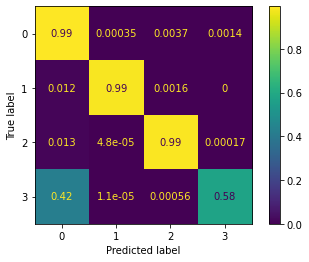

In [76]:
print("TRAIN DATA CONFUSION MATRIX")
sklearn.metrics.plot_confusion_matrix(clf,X_train,y_train,normalize="true")

TEST DATA CONFUSION MATRIX


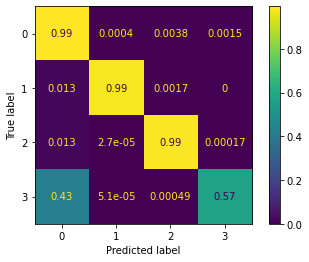

In [77]:
print("TEST DATA CONFUSION MATRIX")
sklearn.metrics.plot_confusion_matrix(clf,X_test,y_test,normalize="true")

* From condusion matrix we can see that diagonals elements are almost close to 1 except  class 3(DIVERTED ATTENTION)

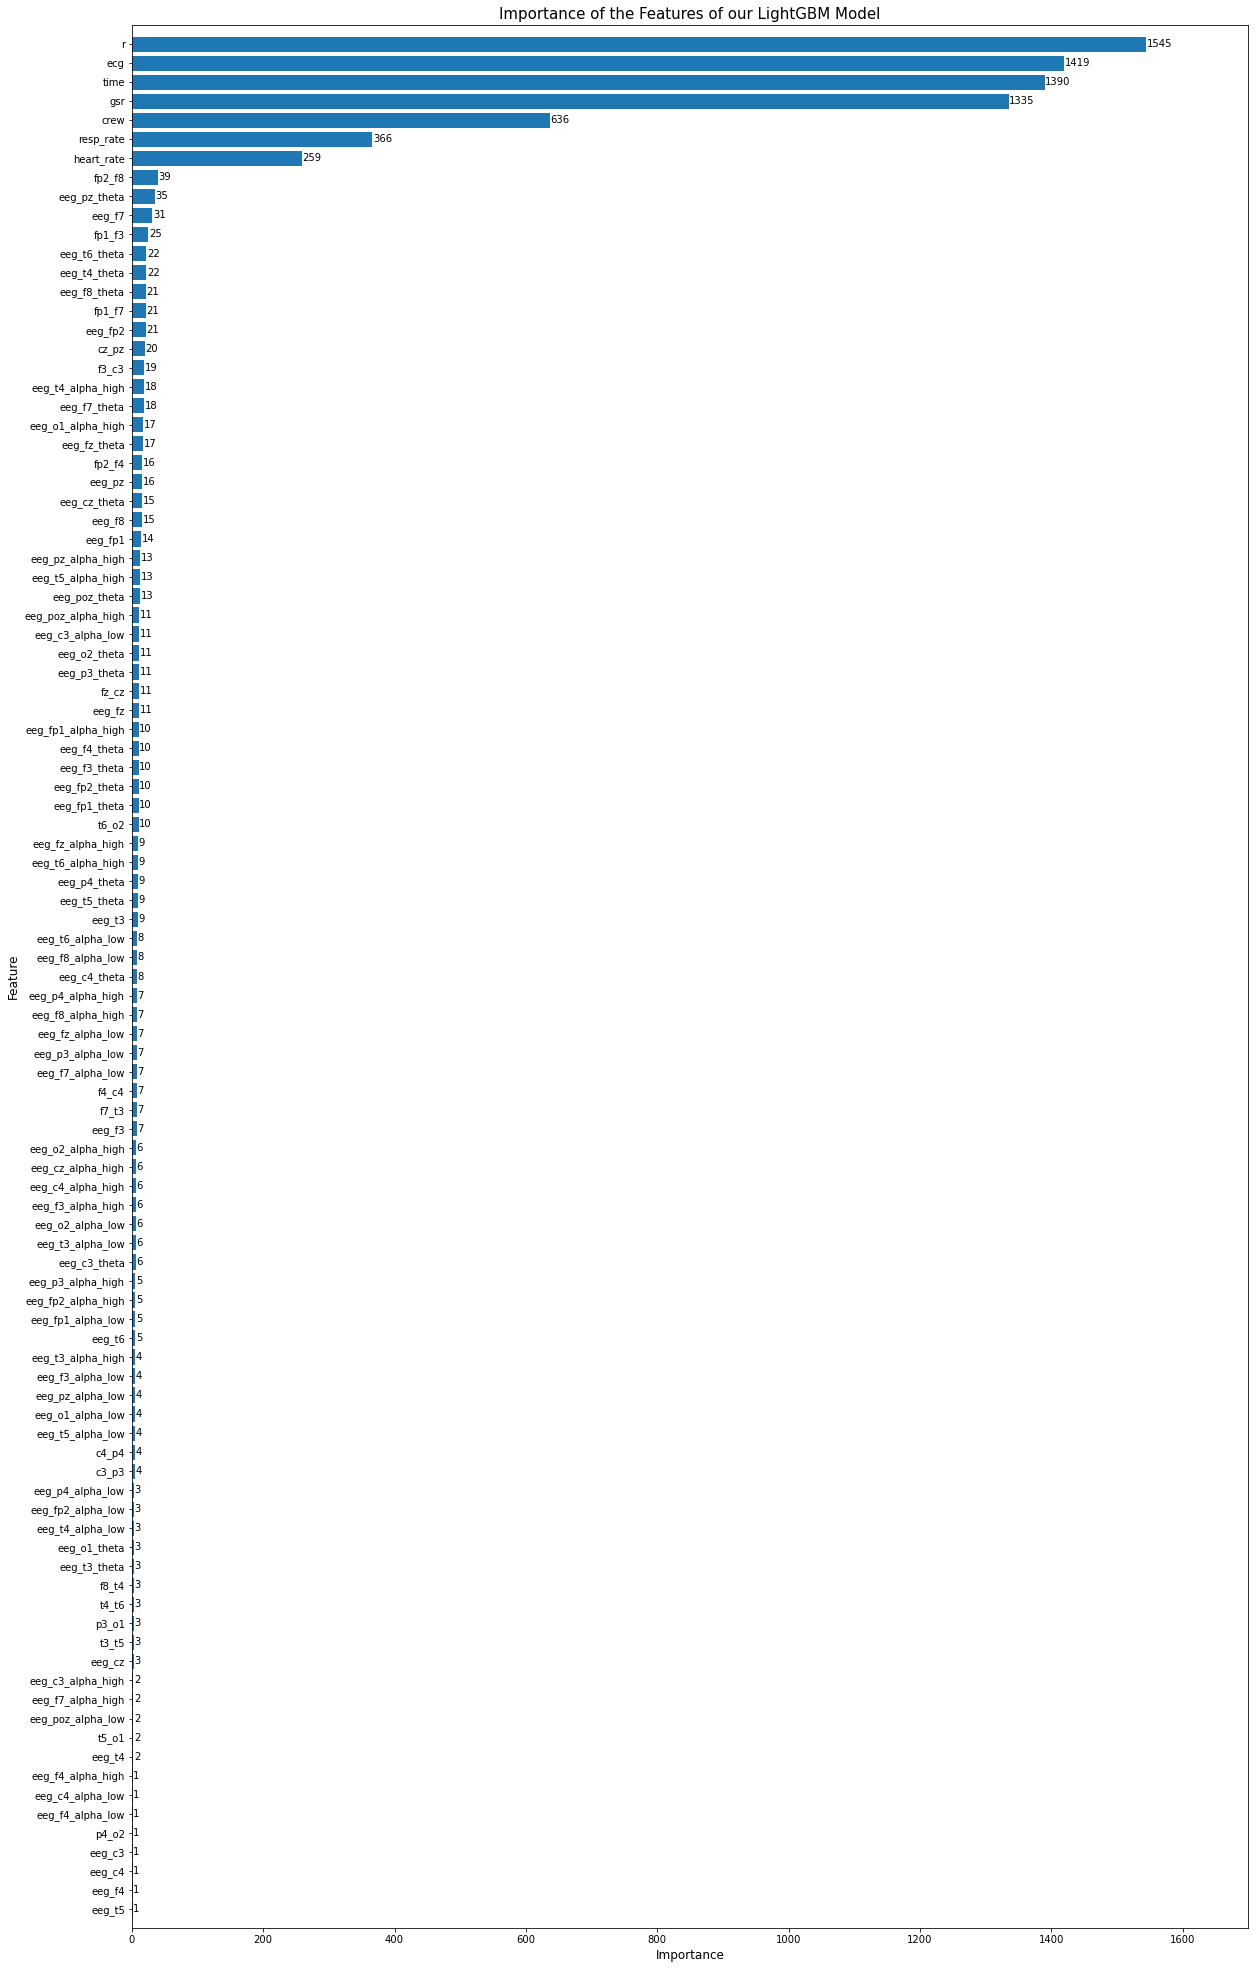

In [85]:
fig, ax = plt.subplots(figsize=(20,35))
lgb.plot_importance(clf, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

* From the feature importance plot, we can see that some of the derived features( heart rate, respiration rate, frequency bands, potential difference) have a major impact on predicting class labels.

In [5]:
from prettytable import PrettyTable 
myTable = PrettyTable(["Sl.no", "Model", "log_loss"]) 
myTable.add_row(["1", "Random Model", "1.645"]) 
myTable.add_row(["2", "Logistic Regression", "0.944" ]) 
myTable.add_row(["3", "Light GBM", "0.119"]) 
print(myTable)

+-------+---------------------+----------+
| Sl.no |        Model        | log_loss |
+-------+---------------------+----------+
|   1   |     Random Model    |  1.645   |
|   2   | Logistic Regression |  0.944   |
|   3   |      Light GBM      |  0.119   |
+-------+---------------------+----------+
